<a href="https://colab.research.google.com/github/xoloshibu/Analitics/blob/master/Ejercicio_clasificaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analítica de datos -Ejercicio - Metodos de clasificación  ---CARLOS ALFREDO VERGARA ROJAS 

## Lectura base de datos y partición conjunto de entrenamiento y conjunto de evaluación



# Se declaran las funciones principales a utilizar sobre el cuaderno


Dimensiones base de datos: 
 (1288, 50, 37)
Clases base de datos: 
 ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']
[[111.666664 125.666664 120.666664 ...  85.666664  80.333336  69.333336]
 [119.333336 134.66667  134.       ...  92.666664  87.333336  72.666664]
 [120.       143.       143.       ...  99.        89.333336  77.      ]
 ...
 [ 69.666664  63.        57.       ... 200.66667  227.       234.      ]
 [ 60.333332  53.333332  47.666668 ... 233.       235.       235.      ]
 [ 56.666668  54.333332  46.333332 ... 233.66667  237.       235.      ]]


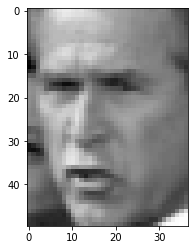

In [1]:
#Paso 1: Lectura
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#para acceder a archivos desde google drive en google colaboratory
#acceso a google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1YjEIJjtUyKl3XSGsc_qJOXoRC1fUKT13' #copiar nombre nombre del link de compartir despues de ID
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('funciones_people.py') 
from funciones_people import pre_exploratorio, save_fig, plot_confusion_matrix, roc_multiclass, roc_auc_mc

from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
#base de datos
from sklearn.datasets import fetch_lfw_people
#https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html


%matplotlib inline
#descargar base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

#ejemplo imagen en base de datos
print('Dimensiones base de datos: \n',lfw_people.images.shape)
plt.imshow(lfw_people.images[30,:,:],cmap='gray')

print('Clases base de datos: \n',lfw_people['target_names'])
print(lfw_people.images[30,:,:])

Dimensiones tipo pandas:  (1288, 1850)


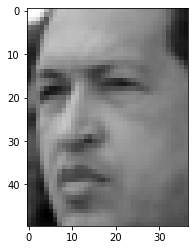

In [2]:
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
plt.imshow(np.array(Xdata.iloc[0,:]).reshape(lfw_people.images.shape[1],lfw_people.images.shape[2]),cmap='gray')


In [3]:
#Paso 2: Particion entrenamiento y validacion
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3) #fijar en 0.3 para entrenar -- 0.95 para demostrar funcionalidad del código

Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
1240,75.666664,50.000000,44.666668,93.666664,137.666672,150.000000,159.000000,166.666672,177.333328,186.000000,187.333328,189.666672,192.000000,194.333328,194.666672,195.000000,198.666672,200.000000,199.333328,200.333328,201.333328,201.000000,200.000000,195.666672,190.000000,185.333328,181.333328,177.000000,176.000000,168.000000,163.333328,150.666672,102.333336,83.333336,110.666664,110.000000,104.333336,53.666668,36.000000,62.000000,...,58.666668,36.000000,59.666668,115.333336,115.000000,113.000000,137.000000,161.666672,116.333336,111.333336,108.000000,100.666664,89.666664,81.000000,79.333336,90.000000,109.000000,128.333328,137.333328,136.333328,139.666672,147.666672,155.666672,154.666672,149.000000,147.333328,139.000000,122.666664,99.666664,76.000000,72.666664,81.333336,108.333336,132.000000,189.000000,204.000000,172.666672,61.333332,20.333334,29.666666
430,128.333328,112.333336,104.000000,101.000000,117.333336,125.666664,124.666664,129.666672,132.000000,133.666672,137.333328,141.666672,151.333328,158.000000,161.333328,165.000000,164.333328,166.666672,169.333328,167.666672,173.666672,170.333328,164.333328,158.666672,153.000000,149.666672,148.666672,145.666672,140.000000,137.000000,133.000000,126.333336,119.000000,117.666664,112.666664,122.333336,131.000000,115.000000,113.666664,106.000000,...,22.666666,18.666666,16.333334,10.333333,7.333333,6.666667,36.333332,142.000000,152.000000,140.333328,114.333336,56.333332,29.333334,32.333332,36.000000,32.666668,32.666668,47.333332,61.666668,68.666664,82.000000,95.000000,101.666664,103.000000,104.333336,99.000000,97.000000,91.333336,80.000000,58.666668,53.333332,71.666664,162.000000,229.333328,222.333328,104.333336,23.333334,21.333334,19.333334,17.666666
395,55.666668,62.000000,85.666664,114.666664,146.000000,165.666672,164.666672,157.666672,148.333328,145.000000,146.333328,149.333328,153.000000,154.666672,157.666672,164.333328,168.000000,168.000000,166.333328,165.666672,165.666672,164.666672,163.000000,159.666672,157.666672,155.666672,153.333328,151.000000,144.666672,134.333328,126.000000,121.333336,113.333336,104.333336,83.333336,41.333332,31.000000,59.333332,71.333336,106.000000,...,181.666672,52.666668,18.000000,38.000000,105.666664,205.333328,219.666672,214.333328,227.666672,236.000000,190.000000,137.666672,121.000000,123.000000,121.666664,118.000000,116.333336,123.666664,136.000000,137.666672,134.666672,132.000000,132.000000,136.333328,136.666672,134.333328,131.000000,128.333328,124.666664,116.000000,101.666664,101.000000,115.000000,144.666672,203.666672,211.666672,212.000000,178.000000,47.666668,19.000000
429,79.333336,90.666664,130.333328,150.000000,152.000000,154.333328,154.333328,154.333328,161.333328,165.666672,163.666672,169.333328,169.333328,169.000000,170.333328,171.666672,170.666672,171.666672,170.333328,164.666672,166.000000,162.666672,157.000000,155.333328,149.333328,143.000000,136.000000,134.666672,127.333336,119.333336,117.333336,107.000000,89.333336,70.000000,79.000000,61.000000,51.333332,82.333336,105.000000,140.666672,...,53.000000,10.333333,9.000000,16.666666,15.333333,15.333333,17.333334,18.000000,21.000000,45.000000,179.666672,217.000000,189.000000,123.333336,88.000000,91.666664,120.666664,145.666672,151.000000,146.666672,144.333328,138.333328,130.333328,141.666672,142.333328,136.000000,127.333336,128.000000,120.333336,100.333336,73.666664,89.000000,106.333336,111.333336,121.666664,143.333328,114.000000,27.666666,12.333333,10.666667
1174,78.666664,89.333336,83.000000,80.666664,94.333336,123.333336,148.666672,166.666672,179.000000,191.333328,202.000000,210.666672,216.666672,215.666672,213.333328,214.333328,212.000000,212.666672,214.000000,213.000000,208.

[t-SNE] Computing 70 nearest neighbors...
[t-SNE] Indexed 901 samples in 0.159s...
[t-SNE] Computed neighbors for 901 samples in 3.170s...
[t-SNE] Computed conditional probabilities for sample 901 / 901
[t-SNE] Mean sigma: 15.253588
[t-SNE] Computed conditional probabilities in 0.058s
[t-SNE] Iteration 50: error = 74.2191162, gradient norm = 0.3715821 (50 iterations in 0.472s)
[t-SNE] Iteration 100: error = 74.9086609, gradient norm = 0.3615087 (50 iterations in 0.480s)
[t-SNE] Iteration 150: error = 75.3081818, gradient norm = 0.3504044 (50 iterations in 0.453s)
[t-SNE] Iteration 200: error = 74.5022125, gradient norm = 0.3467590 (50 iterations in 0.436s)
[t-SNE] Iteration 250: error = 75.1873169, gradient norm = 0.3290109 (50 iterations in 0.421s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.187317
[t-SNE] KL divergence after 251 iterations: 1797693134862315708145274237317043567980705675258449965989174768031572607800285387605895586327668781715404589535143824

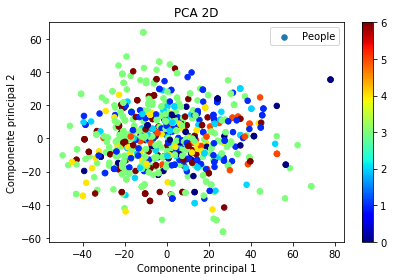

Guardando... relevancia_PCA_eigenface


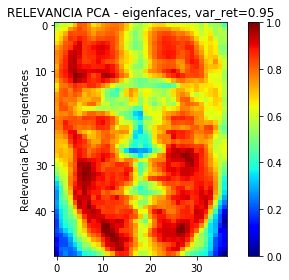

Guardando... tsne_2D


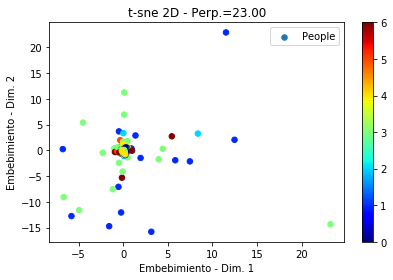

True

In [4]:
#%% Paso 3 : Analisis exploratorio
#preproceso entrada  y salida para analisis exploratorio
img_path = '' #para guardar from google.colab import files plt.savefig("abc.png") files.download("abc.png") 
pre_exploratorio(Xtrain,ytrain,img_path,'People',lfw_people.images.shape[1],lfw_people.images.shape[2])

In [22]:
#%% Paso 4 : Escoger modelo por gridsearchCV utilizando pipeline

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.externals import joblib #https://joblib.readthedocs.io/en/latest/

steps=[[('rep',  PCA()),
        ('cla', LogisticRegression())],
       [('rep',  PCA()),
        ('cla', SGDClassifier())],
       [('rep',  PCA()),
        ('cla', KNeighborsClassifier())],
       [('rep',  PCA()),
        ('cla',GaussianNB())],
       [('rep',  PCA()),
        ('cla', SVC())],
       [('rep',  PCA()),
        ('cla', RandomForestClassifier())],
       
        [('cla', LogisticRegression())],
        [('cla', SGDClassifier())],
        [('cla', KNeighborsClassifier())],
        [('cla', GaussianNB())],
        [('cla', SVC())],
        [('cla', RandomForestClassifier())],
      
      ]
parameters = [{
              'rep__n_components' : [0.8,0.9],              
              'cla__C': [0.5,1],
              },
              {
              'rep__n_components' : [0.8,0.9],              
              'cla__alpha': [0.0001,0.001],
              },
              {
              'rep__n_components' : [0.8,0.9],              
              'cla__n_neighbors': [3,4,5],
              },
              {
              'rep__n_components' : [0.8,0.9],              
            
              },
              {
              'rep__n_components' : [0.8,0.9],              
              'cla__gamma': [0.1,1,10,100],
              },
              {
              'rep__n_components' : [0.8,0.9],              
              'cla__n_estimators': [10,100],
              },
              {             
             'cla__C': [0.1,1,100,500,1e3], 
             },
               {             
             'cla__alpha': [0.0001,0.001],
             },
               {             
            'cla__n_neighbors': [3,4,5],
             },
               {             
 
             },
               {             
             'cla__gamma': [0.1,1,10,100],
             },
               {             
                'cla__n_estimators': [10,100],
             }
             ]

label_models = ['PCA_Logistic','PCA_SGD', 'PCA_knn','PCA_gauss','PCA_Svc','PCA_Randomforest','logistic','SGD','KNN','GAUSS','SVC','RANDOMFOREST']

best_model = []
filename = ''#'resultados/people_comp'
for i in range(len(steps)):
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='balanced_accuracy',verbose=10)
    grid_search.fit(Xtrain, ytrain)
    #print(grid_search.cv_results_)
    #mejor modelo entrenado
    best_model += [grid_search.best_estimator_]
    joblib.dump(best_model,filename+".pkl")

print('Mejores modelos:\n')
best_model

modelo 1/12
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    8.3s finished


modelo 2/12
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    7.9s finished


modelo 3/12
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.6s finished


modelo 4/12
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s finished


modelo 5/12
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   17.6s finished


modelo 6/12
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   10.7s finished


modelo 7/12
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   20.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   20.0s finished


modelo 8/12
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.2s finished


modelo 9/12
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    6.6s finished


modelo 10/12
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0574s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


modelo 11/12
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   39.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   39.3s finished


modelo 12/12
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.0s finished


Mejores modelos:



[Pipeline(memory=None,
          steps=[('rep',
                  PCA(copy=True, iterated_power='auto', n_components=0.9,
                      random_state=None, svd_solver='auto', tol=0.0,
                      whiten=False)),
                 ('cla',
                  LogisticRegression(C=0.5, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=100,
                                     multi_class='auto', n_jobs=None,
                                     penalty='l2', random_state=None,
                                     solver='lbfgs', tol=0.0001, verbose=0,
                                     warm_start=False))],
          verbose=False), Pipeline(memory=None,
          steps=[('rep',
                  PCA(copy=True, iterated_power='auto', n_components=0.9,
                      random_state=None, svd_solver='auto', tol=0.0,
                      whiten=False)),

# Calcular rendimiento en cojunto de test

Evaluando modelo 1/12


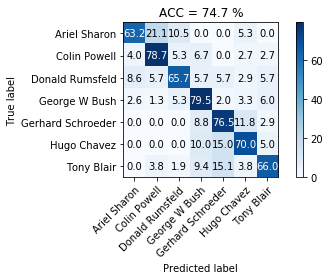

                   precision    recall  f1-score   support

     Ariel Sharon       0.55      0.63      0.59        19
     Colin Powell       0.86      0.79      0.82        75
  Donald Rumsfeld       0.61      0.66      0.63        35
    George W Bush       0.88      0.79      0.83       151
Gerhard Schroeder       0.62      0.76      0.68        34
      Hugo Chavez       0.48      0.70      0.57        20
       Tony Blair       0.70      0.66      0.68        53

         accuracy                           0.75       387
        macro avg       0.67      0.71      0.69       387
     weighted avg       0.76      0.75      0.75       387

Evaluando modelo 2/12


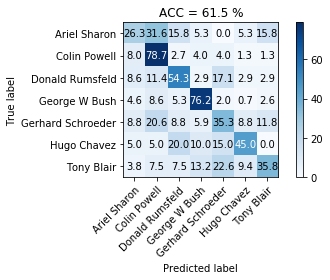

                   precision    recall  f1-score   support

     Ariel Sharon       0.19      0.26      0.22        19
     Colin Powell       0.63      0.79      0.70        75
  Donald Rumsfeld       0.44      0.54      0.49        35
    George W Bush       0.88      0.76      0.82       151
Gerhard Schroeder       0.31      0.35      0.33        34
      Hugo Chavez       0.43      0.45      0.44        20
       Tony Blair       0.59      0.36      0.45        53

         accuracy                           0.61       387
        macro avg       0.49      0.50      0.49       387
     weighted avg       0.64      0.61      0.62       387

Evaluando modelo 3/12


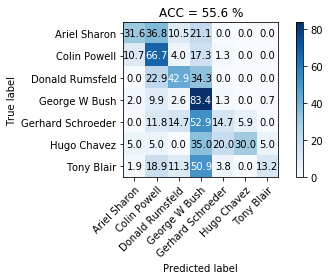

                   precision    recall  f1-score   support

     Ariel Sharon       0.32      0.32      0.32        19
     Colin Powell       0.53      0.67      0.59        75
  Donald Rumsfeld       0.43      0.43      0.43        35
    George W Bush       0.61      0.83      0.70       151
Gerhard Schroeder       0.36      0.15      0.21        34
      Hugo Chavez       0.75      0.30      0.43        20
       Tony Blair       0.78      0.13      0.23        53

         accuracy                           0.56       387
        macro avg       0.54      0.40      0.41       387
     weighted avg       0.57      0.56      0.51       387

Evaluando modelo 4/12


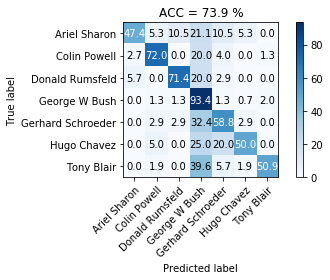

                   precision    recall  f1-score   support

     Ariel Sharon       0.69      0.47      0.56        19
     Colin Powell       0.90      0.72      0.80        75
  Donald Rumsfeld       0.83      0.71      0.77        35
    George W Bush       0.69      0.93      0.79       151
Gerhard Schroeder       0.57      0.59      0.58        34
      Hugo Chavez       0.71      0.50      0.59        20
       Tony Blair       0.87      0.51      0.64        53

         accuracy                           0.74       387
        macro avg       0.75      0.63      0.68       387
     weighted avg       0.76      0.74      0.73       387

Evaluando modelo 5/12


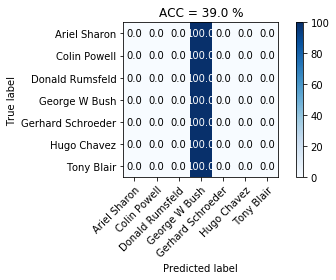

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        19
     Colin Powell       0.00      0.00      0.00        75
  Donald Rumsfeld       0.00      0.00      0.00        35
    George W Bush       0.39      1.00      0.56       151
Gerhard Schroeder       0.00      0.00      0.00        34
      Hugo Chavez       0.00      0.00      0.00        20
       Tony Blair       0.00      0.00      0.00        53

         accuracy                           0.39       387
        macro avg       0.06      0.14      0.08       387
     weighted avg       0.15      0.39      0.22       387

Evaluando modelo 6/12


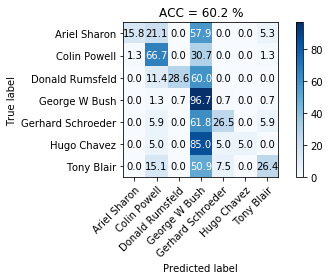

                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.16      0.26        19
     Colin Powell       0.70      0.67      0.68        75
  Donald Rumsfeld       0.91      0.29      0.43        35
    George W Bush       0.55      0.97      0.70       151
Gerhard Schroeder       0.60      0.26      0.37        34
      Hugo Chavez       1.00      0.05      0.10        20
       Tony Blair       0.74      0.26      0.39        53

         accuracy                           0.60       387
        macro avg       0.75      0.38      0.42       387
     weighted avg       0.67      0.60      0.55       387

Evaluando modelo 7/12


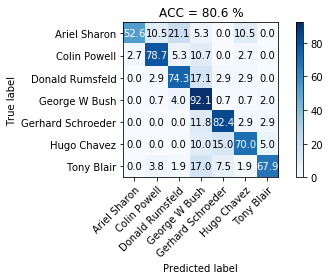

                   precision    recall  f1-score   support

     Ariel Sharon       0.83      0.53      0.65        19
     Colin Powell       0.91      0.79      0.84        75
  Donald Rumsfeld       0.63      0.74      0.68        35
    George W Bush       0.82      0.92      0.87       151
Gerhard Schroeder       0.76      0.82      0.79        34
      Hugo Chavez       0.64      0.70      0.67        20
       Tony Blair       0.88      0.68      0.77        53

         accuracy                           0.81       387
        macro avg       0.78      0.74      0.75       387
     weighted avg       0.81      0.81      0.80       387

Evaluando modelo 8/12


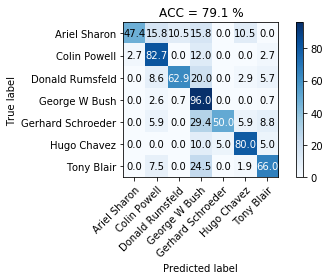

                   precision    recall  f1-score   support

     Ariel Sharon       0.82      0.47      0.60        19
     Colin Powell       0.79      0.83      0.81        75
  Donald Rumsfeld       0.88      0.63      0.73        35
    George W Bush       0.77      0.96      0.85       151
Gerhard Schroeder       0.94      0.50      0.65        34
      Hugo Chavez       0.73      0.80      0.76        20
       Tony Blair       0.80      0.66      0.72        53

         accuracy                           0.79       387
        macro avg       0.82      0.69      0.73       387
     weighted avg       0.80      0.79      0.78       387

Evaluando modelo 9/12


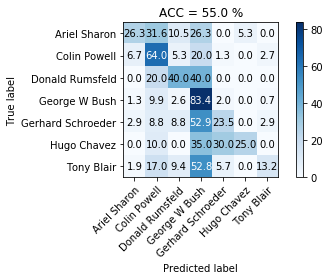

                   precision    recall  f1-score   support

     Ariel Sharon       0.36      0.26      0.30        19
     Colin Powell       0.53      0.64      0.58        75
  Donald Rumsfeld       0.44      0.40      0.42        35
    George W Bush       0.59      0.83      0.69       151
Gerhard Schroeder       0.38      0.24      0.29        34
      Hugo Chavez       0.83      0.25      0.38        20
       Tony Blair       0.64      0.13      0.22        53

         accuracy                           0.55       387
        macro avg       0.54      0.39      0.41       387
     weighted avg       0.55      0.55      0.51       387

Evaluando modelo 10/12


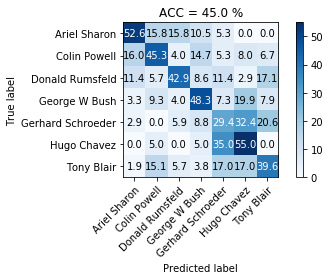

                   precision    recall  f1-score   support

     Ariel Sharon       0.30      0.53      0.38        19
     Colin Powell       0.55      0.45      0.50        75
  Donald Rumsfeld       0.47      0.43      0.45        35
    George W Bush       0.77      0.48      0.59       151
Gerhard Schroeder       0.22      0.29      0.25        34
      Hugo Chavez       0.16      0.55      0.25        20
       Tony Blair       0.41      0.40      0.40        53

         accuracy                           0.45       387
        macro avg       0.41      0.45      0.40       387
     weighted avg       0.55      0.45      0.48       387

Evaluando modelo 11/12


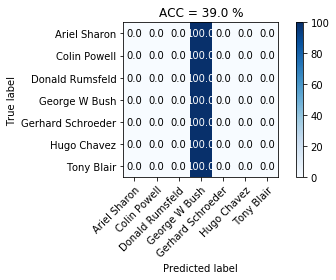

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        19
     Colin Powell       0.00      0.00      0.00        75
  Donald Rumsfeld       0.00      0.00      0.00        35
    George W Bush       0.39      1.00      0.56       151
Gerhard Schroeder       0.00      0.00      0.00        34
      Hugo Chavez       0.00      0.00      0.00        20
       Tony Blair       0.00      0.00      0.00        53

         accuracy                           0.39       387
        macro avg       0.06      0.14      0.08       387
     weighted avg       0.15      0.39      0.22       387

Evaluando modelo 12/12


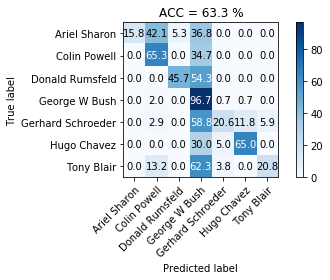

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.16      0.27        19
     Colin Powell       0.72      0.65      0.69        75
  Donald Rumsfeld       0.94      0.46      0.62        35
    George W Bush       0.57      0.97      0.72       151
Gerhard Schroeder       0.64      0.21      0.31        34
      Hugo Chavez       0.72      0.65      0.68        20
       Tony Blair       0.85      0.21      0.33        53

         accuracy                           0.63       387
        macro avg       0.78      0.47      0.52       387
     weighted avg       0.70      0.63      0.59       387



In [23]:
#%% Paso 5: evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %d/%d' % (i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)
     
    plot_confusion_matrix(
                          ytest, ytest_e, 
                          classes=lfw_people.target_names,
                          normalize=True,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
   # save_fig(path_img,label_models[i])                      
    plt.show()
    
    cr = classification_report(
                               ytest, ytest_e, 
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )                          
    #support = #muestras en la clase estudiada
    print(cr)


## Curva ROC multiclase - sobre conjunto de test

Evaluando ROC modelo 1/12
Guardando... ROC curve PCA_Logistic


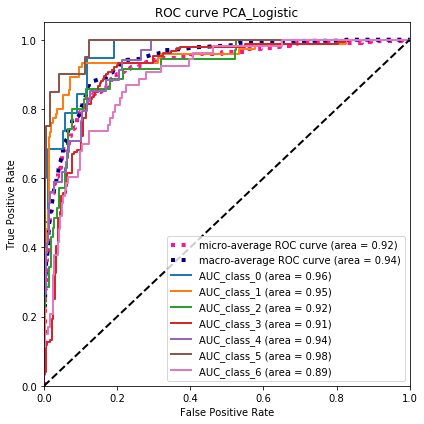

Evaluando ROC modelo 2/12
Guardando... ROC curve PCA_SGD


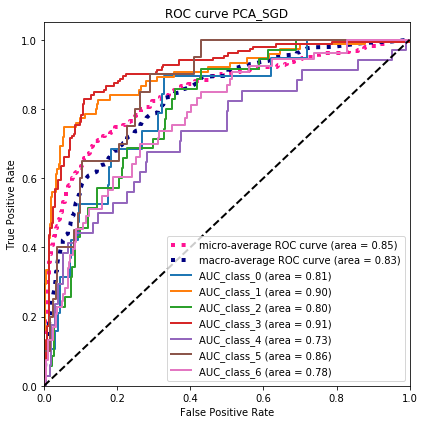

Evaluando ROC modelo 3/12
Guardando... ROC curve PCA_knn


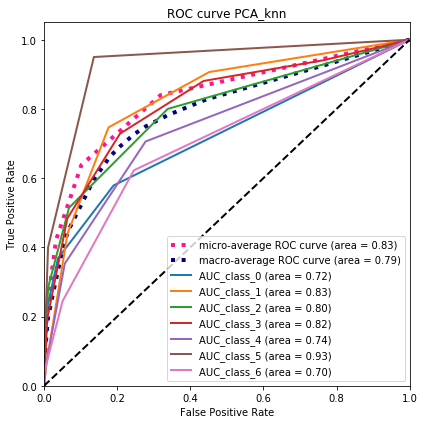

Evaluando ROC modelo 4/12
Guardando... ROC curve PCA_gauss


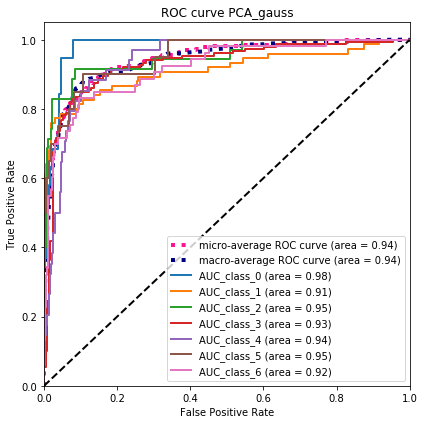

Evaluando ROC modelo 5/12
Guardando... ROC curve PCA_Svc


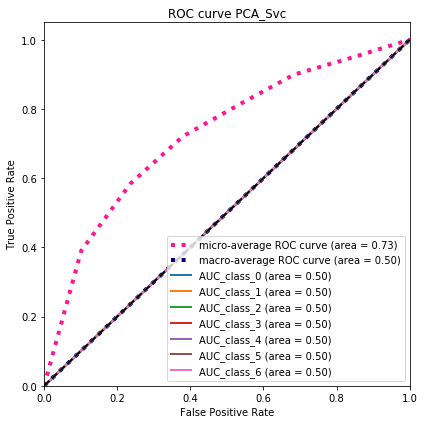

Evaluando ROC modelo 6/12
Guardando... ROC curve PCA_Randomforest


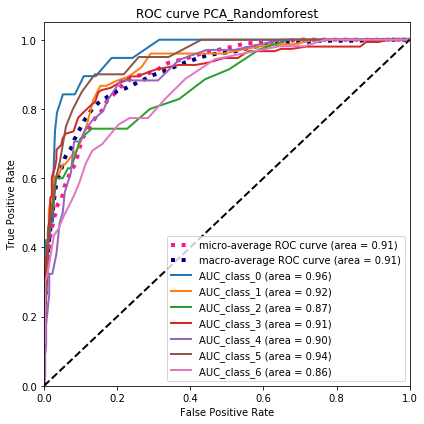

Evaluando ROC modelo 7/12
Guardando... ROC curve logistic


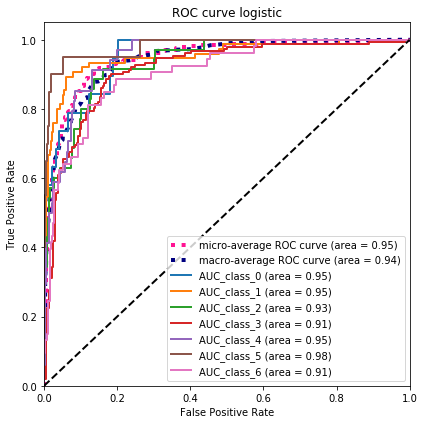

Evaluando ROC modelo 8/12
Guardando... ROC curve SGD


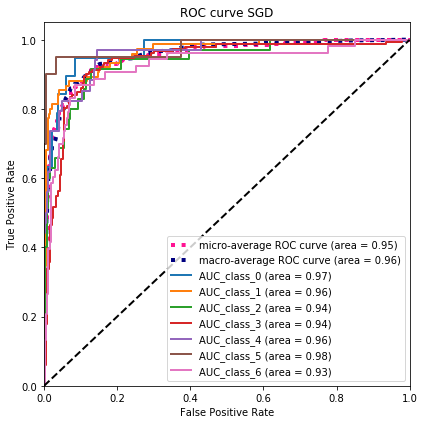

Evaluando ROC modelo 9/12
Guardando... ROC curve KNN


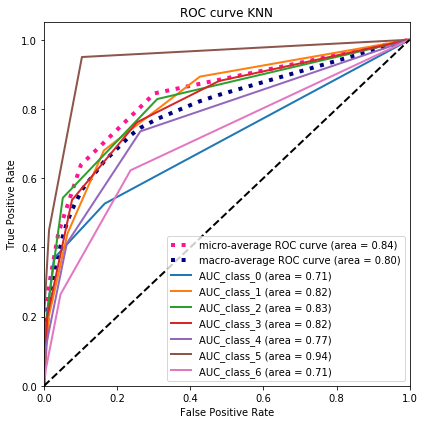

Evaluando ROC modelo 10/12
Guardando... ROC curve GAUSS


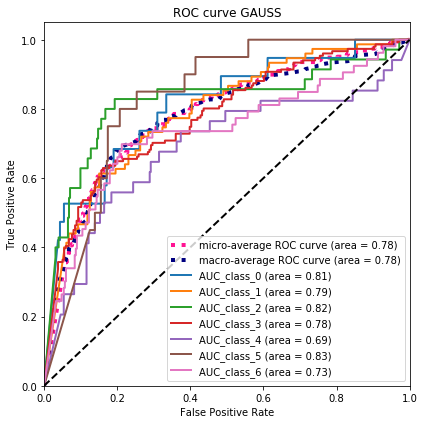

Evaluando ROC modelo 11/12
Guardando... ROC curve SVC


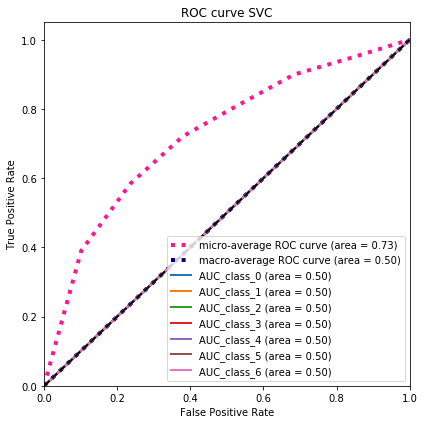

Evaluando ROC modelo 12/12
Guardando... ROC curve RANDOMFOREST


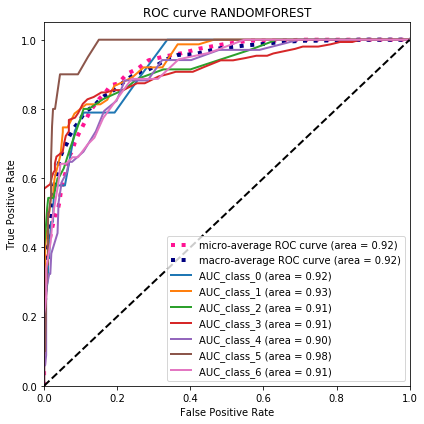

In [24]:
from sklearn.preprocessing import label_binarize

nombres_clas=[0,1,2,3,4,5,6,7,8,9,10,11]

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(12):
    print('Evaluando ROC modelo %d/%d' % (i+1,len(my_model_loaded)))
    if (nombres_clas[i]==0 or nombres_clas[i]==1 or nombres_clas[i]==4 or nombres_clas[i]==6 or nombres_clas[i]==7 or nombres_clas[i]==10) :
      ytest_score = my_model_loaded[i].decision_function(Xtest) #debe calcularse la funcion de decision o el posterior de la probabilidad
      roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
      roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)
    elif (nombres_clas[i]==2 or nombres_clas[i]==3 or nombres_clas[i]==3 or nombres_clas[i]==5  or nombres_clas[i]==8 or nombres_clas[i]==9 or nombres_clas[i]==11 ):
      ytest_score = my_model_loaded[i].predict_proba(Xtest) #debe calcularse la funcion de decision o el posterior de la probabilidad
      roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
      roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)

In [0]:
my_model_loaded[0]